# Intrusion Detection in IoT Networks

Install the required packages

In [ ]:
!nvidia-smi

Sat Aug  9 00:50:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!python3 -m venv --without-pip tf
!source tf/bin/activate && pip install pip

In [ ]:
!source tf/bin/activate

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install tensorflow[and-cuda]

In [ ]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-08-09 00:52:01.124455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754700721.161870    3238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754700721.172790    3238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754700721.198956    3238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754700721.199014    3238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754700721.199024    3238 computation_placer.cc:177] computation placer alr

### Install TensorFlow Model Optimization

In [ ]:
!pip install --user --upgrade tensorflow-model-optimization

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/RT_IOT2022_v1.csv')

# Drop non-numeric columns that shouldn't be scaled
non_numeric_cols = ['proto', 'service', 'Attack_type']  # modify this list if needed
numeric_df = df.drop(columns=non_numeric_cols)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Convert back to DataFrame for clarity
scaled_df = pd.DataFrame(X_scaled, columns=numeric_df.columns)

# Optional: Display first few rows
print(scaled_df.head())


         no  id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0 -1.215900   0.211202   0.165266       0.216931      0.301353        0.0936   
1 -1.215868   0.865405   0.165266       0.215946      0.301353        0.0936   
2 -1.215835   0.530753   0.165266       0.217796      0.301353        0.0936   
3 -1.215802   1.376665   0.165266       0.216542      0.301353        0.0936   
4 -1.215769   0.862468   0.165266       0.216090      0.301353        0.0936   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0            0.07786           0.067497          -0.94887         -0.948656   
1            0.07786           0.067497          -0.94887         -0.948656   
2            0.07786           0.067497          -0.94887         -0.948656   
3            0.07786           0.067497          -0.94887         -0.948656   
4            0.07786           0.067497          -0.94887         -0.948656   

   ...  active.avg  active.std  idle.min  id

In [ ]:
# Define attack types
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Count occurrences
benign_count = rtiot_df_v2['Attack_type'].isin(benign_attacks).sum()
harmful_count = rtiot_df_v2['Attack_type'].isin(harmful_attacks).sum()

# Output result
print(f"🟢 Number of benign attacks:  {benign_count}")
print(f"🔴 Number of harmful attacks: {harmful_count}")


🟢 Number of benign attacks:  12507
🔴 Number of harmful attacks: 110610


### Fix class imbalance with SMOTE- Logistic Regression

In [ ]:
!pip install imblearn

Logistic Regression model (Baseline Model)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Define attack categories ---
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Create binary labels ---
df['attack_label'] = df['Attack_type'].apply(
    lambda x: 1 if x in harmful_attacks else (0 if x in benign_attacks else np.nan)
)
df = df.dropna(subset=['attack_label'])  # drop undefined samples
y = df['attack_label'].astype(int)

# Select numeric features and scale them ---
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to balance the training set ---
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model ---
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set ---
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Harmful"]))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.80      0.98      0.88      2501
     Harmful       1.00      0.97      0.98     22123

    accuracy                           0.97     24624
   macro avg       0.90      0.98      0.93     24624
weighted avg       0.98      0.97      0.97     24624


🧩 Confusion Matrix:
[[ 2462    39]
 [  621 21502]]


Random Forest


📊 Classification Report (Random Forest):
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      1.00      0.99      1550
            DDOS_Slowloris       0.93      0.95      0.94       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       1.00      0.86      0.92         7
             NMAP_FIN_SCAN       1.00      0.67      0.80         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.99      0.98      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       1.00      0.99      1.00      1622
                Wipro_bulb       1.00      0.98      0.99        51

                  accuracy                           1.00     24624
    

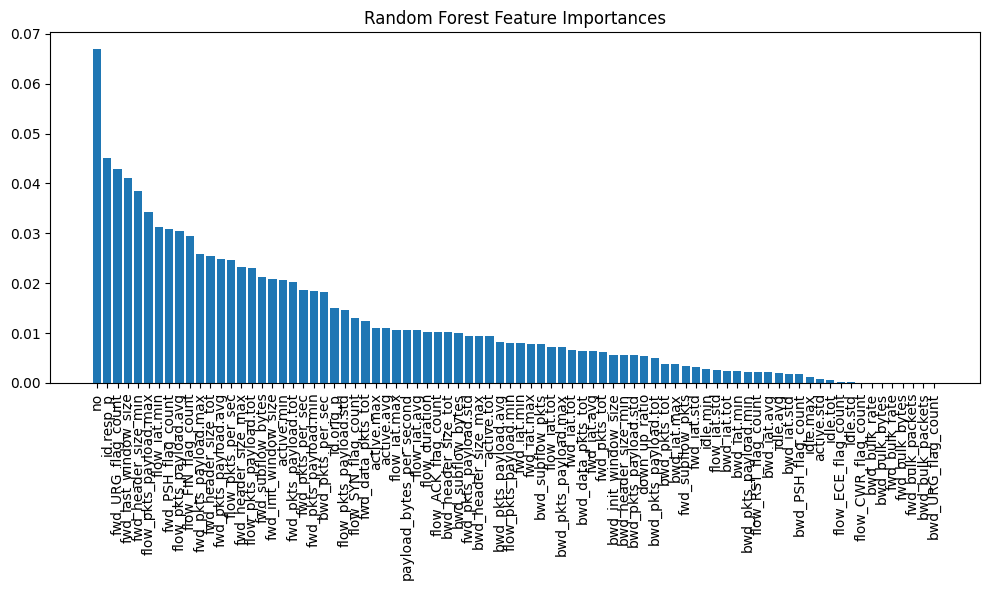

In [ ]:
# Random Forest Multiclass Classification

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Load + shuffle
df = pd.read_csv('/content/RT_IOT2022_v1.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',            # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]
df = df[df['Attack_type'].isin(valid_attacks)].copy()

# Labels (multiclass)
le = LabelEncoder()
df['attack_label'] = le.fit_transform(df['Attack_type'])
y = df['attack_label'].values
num_classes = len(le.classes_)

# Features + scaling
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Save scaler for later use
joblib.dump(scaler, 'scaler_rf.joblib')

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # 60/20/20

# Class weights (helps rare classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight=class_weight_dict,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)

print("\n📊 Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf, 'random_forest_model.joblib')
print("\n✅ Random Forest model saved as 'random_forest_model.joblib'.")

# Feature Importance
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_raw.shape[1]), importances[indices], align="center")
plt.xticks(range(X_raw.shape[1]), X_raw.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

MLP Classifier Code with SMOTE and Evaluation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Load dataset ---
df = pd.read_csv('/content/RT_IOT2022_v1.csv')

# Define attack types ---
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Create binary label ---
df['attack_label'] = df['Attack_type'].apply(
    lambda x: 1 if x in harmful_attacks else (0 if x in benign_attacks else np.nan)
)
df = df.dropna(subset=['attack_label'])
y = df['attack_label'].astype(int)

# Prepare features ---
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Build MLP Model ---
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with EarlyStopping ---
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation ---
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Harmful"]))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Epoch 1/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9673 - loss: 0.1001 - val_accuracy: 0.9917 - val_loss: 0.0343
Epoch 2/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 0.9954 - val_loss: 0.0200
Epoch 3/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9942 - loss: 0.0197 - val_accuracy: 0.9971 - val_loss: 0.0164
Epoch 4/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9950 - loss: 0.0170 - val_accuracy: 0.9974 - val_loss: 0.0121
Epoch 5/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9950 - loss: 0.0175 - val_accuracy: 0.9985 - val_loss: 0.0101
Epoch 6/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9952 - loss: 0.0150 - val_accuracy: 0.9978 - val_loss: 0.0135
Epoch 7/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9955 - loss: 0.0150 - val_accuracy: 0.9976 - val_loss: 0.0143
Epoch 8/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9956 - loss: 0

MLP for Multiclass Attack Classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, callbacks

# Load and Shuffle the Dataset ---
df = pd.read_csv('/content/RT_IOT2022_v1.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Filter only defined attacks (benign or harmful) ---
valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',  # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]

df_filtered = df[df['Attack_type'].isin(valid_attacks)].copy()

# Encode Attack_type as multiclass labels ---
le = LabelEncoder()
df_filtered['attack_label'] = le.fit_transform(df_filtered['Attack_type'])
y = to_categorical(df_filtered['attack_label'])  # one-hot for multiclass

# Prepare Features ---
X_raw = df_filtered.drop(columns=['proto', 'service', 'Attack_type', 'attack_label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split into Train, Validation, Test ---
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 of 80% = 20%

# Build MLP Model for Multiclass Classification ---
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(y_train.shape[1], activation='softmax')  # multiclass
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model with EarlyStopping ---
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate Model ---
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))


Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9286 - loss: 0.2769 - val_accuracy: 0.9803 - val_loss: 0.0616
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9826 - loss: 0.0604 - val_accuracy: 0.9885 - val_loss: 0.0454
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9870 - loss: 0.0487 - val_accuracy: 0.9918 - val_loss: 0.0400
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9894 - loss: 0.0358 - val_accuracy: 0.9928 - val_loss: 0.0410
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9901 - loss: 0.0340 - val_accuracy: 0.9929 - val_loss: 0.0475
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9914 - loss: 0.0292 - val_accuracy: 0.9939 - val_loss: 0.0427
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9915 - loss: 0.0304 - val_accuracy: 0.9922 - val_loss: 0.0487
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9913 - loss: 0.0303 

Quantized MLP Model for IoT Deployment

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Load & Shuffle Dataset ---
df = pd.read_csv('/content/RT_IOT2022_v1.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Filter Valid Attacks ---
valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]
df = df[df['Attack_type'].isin(valid_attacks)].copy()

# Encode Labels ---
le = LabelEncoder()
df['attack_label'] = le.fit_transform(df['Attack_type'])
y_int = df['attack_label'].values
y_cat = to_categorical(y_int)

# Feature Preprocessing ---
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split Dataset ---
X_temp, X_test, y_temp_cat, y_test_cat, y_temp_int, y_test_int = train_test_split(
    X_scaled, y_cat, y_int, test_size=0.2, stratify=y_int, random_state=42)

X_train, X_val, y_train_cat, y_val_cat, y_train_int, y_val_int = train_test_split(
    X_temp, y_temp_cat, y_temp_int, test_size=0.25, stratify=y_temp_int, random_state=42)

# Compute Class Weights ---
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_int),
                                     y=y_train_int)
class_weight_dict = dict(enumerate(class_weights))

# Define Lightweight MLP Model ---
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model ---
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train_cat,
          validation_data=(X_val, y_val_cat),
          epochs=50,
          batch_size=32,
          class_weight=class_weight_dict,
          callbacks=[early_stop],
          verbose=1)

# Evaluate on Test Set ---
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_cat, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=le.classes_))
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_true_class, y_pred_class))

# Quantize the Model for IoT (TFLite) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable post-training quantization
tflite_model = converter.convert()

# Save the Quantized Model ---
with open("quantized_iot_model.tflite", "wb") as f:
    f.write(tflite_model)

print("\n✅ Model successfully quantized and saved as 'quantized_iot_model.tflite'")


Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8618 - loss: 1.0151 - val_accuracy: 0.9556 - val_loss: 0.1572
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9692 - loss: 0.2659 - val_accuracy: 0.9773 - val_loss: 0.0770
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9775 - loss: 0.1626 - val_accuracy: 0.9794 - val_loss: 0.0739
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9822 - loss: 0.2545 - val_accuracy: 0.9519 - val_loss: 0.1353
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9781 - loss: 0.1513 - val_accuracy: 0.9859 - val_loss: 0.0717
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9889 - loss: 0.1246 - val_accuracy: 0.9685 - val_loss: 0.1184
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9858 - loss: 0.1077 - val_accuracy: 0.9885 - val_loss: 0.0587
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9890 - loss: 0.100

Simulate the IoT device Raspberry Pi

Saved artifact at '/tmp/tmpdlpqx6dz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_96')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  136817959563920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817959561424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817953284624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817953290768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817953282704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817953279632: TensorSpec(shape=(), dtype=tf.resource, name=None)
Average Inference Time: 0.016 ms
Standard Deviation: 0.111 ms


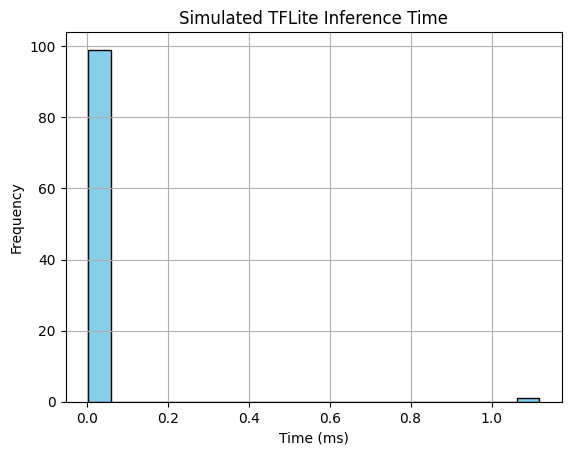

In [ ]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Build a small MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Convert to quantized TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Load with TFLite Interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Measure inference times
times = []
for _ in range(100):
    input_data = np.random.rand(1, 50).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    start = time.time()
    interpreter.invoke()
    _ = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()
    times.append((end - start) * 1000)  # ms

# Display results
print(f"Average Inference Time: {np.mean(times):.3f} ms")
print(f"Standard Deviation: {np.std(times):.3f} ms")

plt.hist(times, bins=20, color='skyblue', edgecolor='black')
plt.title("Simulated TFLite Inference Time")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Final MLP Combo Model- Original MLP  ->  TFLite (dynamic range)  +  TFLite (INT8)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

# Load + shuffle + filter
df = pd.read_csv('/content/RT_IOT2022_v1.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',            # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]
df = df[df['Attack_type'].isin(valid_attacks)].copy()

# Labels (multiclass)
le = LabelEncoder()
df['attack_label'] = le.fit_transform(df['Attack_type'])
y = df['attack_label'].values
num_classes = len(le.classes_)

# Features + scaling
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Save the scaler to reuse on-device or server-side preprocessing
joblib.dump(scaler, 'scaler.joblib')

# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # => 60/20/20

# Class weights (helps rare classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Build lightweight MLP
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate original MLP
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n📊 Classification Report (Original MLP):")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save original MLP
original_path = 'original_mlp_model.h5'
model.save(original_path)

# TFLite (Dynamic Range) quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]   # dynamic-range quant
tflite_dynamic = converter.convert()

dynamic_path = 'model_dynamic.tflite'
with open(dynamic_path, 'wb') as f:
    f.write(tflite_dynamic)

# TFLite (Full INT8) quantization
#     Uses representative data for proper calibration.
#     Note: INT8 IO requires int8 tensors on-device; keep scaler in pipeline.
def representative_data_gen():
    # Take a small sample from training data (float32) for calibration
    for i in range(min(200, X_train.shape[0])):
        yield [X_train[i:i+1].astype(np.float32)]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_data_gen
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8
tflite_int8 = converter_int8.convert()

int8_path = 'model_int8.tflite'
with open(int8_path, 'wb') as f:
    f.write(tflite_int8)

# Size comparison
def size_kb(p): return os.path.getsize(p) / 1024
print("\n📦 File sizes:")
print(f" - Original Keras (.h5): {size_kb(original_path):.2f} KB")
print(f" - TFLite Dynamic:       {size_kb(dynamic_path):.2f} KB")
print(f" - TFLite INT8:          {size_kb(int8_path):.2f} KB")

reduction_dyn = 100 * (size_kb(original_path) - size_kb(dynamic_path)) / size_kb(original_path)
reduction_int8 = 100 * (size_kb(original_path) - size_kb(int8_path)) / size_kb(original_path)
print(f"\n🔻 Reduction vs Original — Dynamic: {reduction_dyn:.1f}% | INT8: {reduction_int8:.1f}%")

# quick TFLite sanity check
def tflite_infer(model_path, sample):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    inp = interpreter.get_input_details()[0]
    out = interpreter.get_output_details()[0]
    x = sample.astype(np.float32)

    # For INT8 model, quantize input using input scale/zero-point
    if 'int8' in model_path:
        scale, zero = inp['quantization']
        x = (x / scale + zero).astype(np.int8)

    interpreter.set_tensor(inp['index'], x)
    interpreter.invoke()
    y = interpreter.get_tensor(out['index'])

    # Dequantize INT8 output back to float for readability
    if 'int8' in model_path:
        scale, zero = out['quantization']
        y = (y.astype(np.float32) - zero) * scale
    return y

sample = X_test[:1]
_ = tflite_infer(dynamic_path, sample)
_ = tflite_infer(int8_path, sample)
print("\n✅ TFLite models loaded and ran a sample inference successfully.")


Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8651 - loss: 1.1467 - val_accuracy: 0.9724 - val_loss: 0.1008
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9743 - loss: 0.2150 - val_accuracy: 0.9757 - val_loss: 0.0831
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9805 - loss: 0.1532 - val_accuracy: 0.9839 - val_loss: 0.0733
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9859 - loss: 0.1225 - val_accuracy: 0.9858 - val_loss: 0.0717
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9870 - loss: 0.1144 - val_accuracy: 0.9849 - val_loss: 0.0759
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9848 - loss: 0.1444 - val_accuracy: 0.9645 - val_loss: 0.2557
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9850 - loss: 0.1734 - val_accuracy: 0.9820 - val_loss: 0.0817
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9885 - loss: 0.1246


📊 Classification Report (Original MLP):
                            precision    recall  f1-score   support

            ARP_poisioning       0.92      0.97      0.94      1550
            DDOS_Slowloris       0.71      0.97      0.82       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       0.43      0.86      0.57         7
             NMAP_FIN_SCAN       0.57      0.67      0.62         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       1.00      0.92      0.95       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.98      0.91      0.95      1622
                Wipro_bulb       0.72      0.98      0.83        51

                  accuracy                           0.99     24624
     

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
